### Model import and Gpu settings

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Define Augmentation

In [3]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
         ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [5]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [6]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

In [7]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Data load

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteMIMHDJ/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteMIMHDJ/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


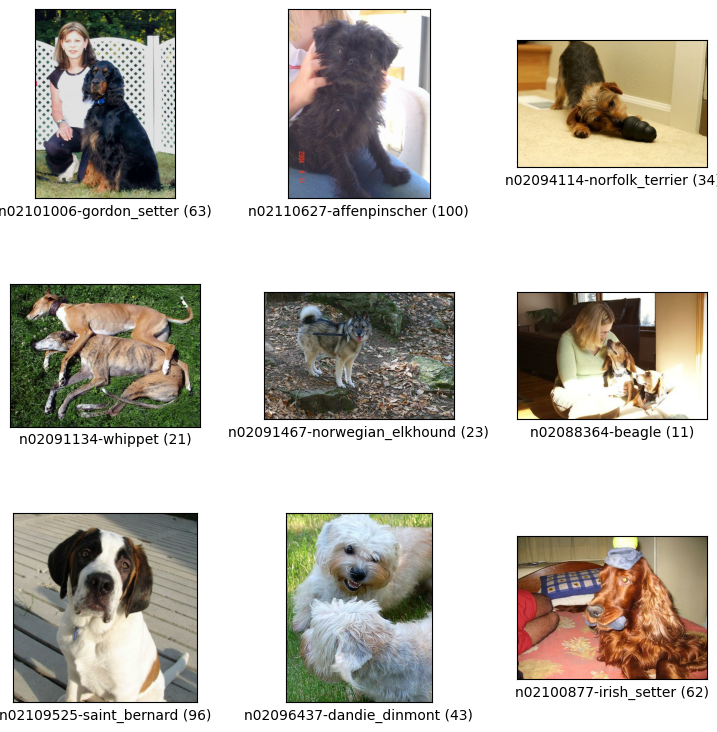

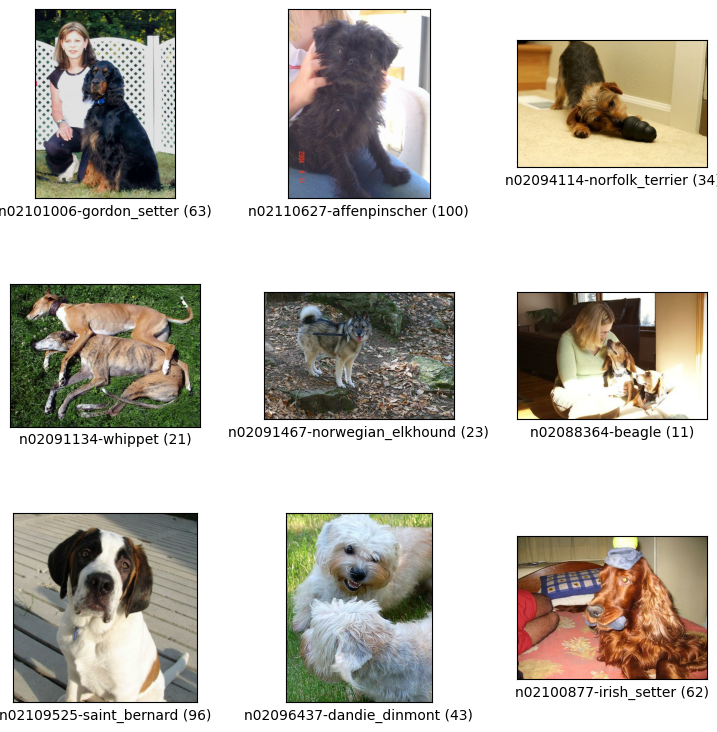

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
tfds.show_examples(ds_train, ds_info)

### Data Augmentation

In [9]:
num_classes = ds_info.features["label"].num_classes
batch_size = 128

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

# mixup 함수를 적용하여 데이터셋 변환
# ds_train_mixup = ds_train_aug.map(lambda image, label: mixup(image, label, batch_size=batch_size, img_size=224, num_classes=num_classes))
# cutmix 함수를 적용하여 데이터셋 변환
# ds_train_cutmix = ds_train_aug.map(lambda image, label: cutmix(image, label, batch_size=batch_size, img_size=224, num_classes=num_classes))

ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### Model settup and compile

In [17]:
EPOCH = 30
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

94765736/94765736 [==============================] - 5s 0us/step


Epoch 1/30
750/750 [==============================] - 196s 208ms/step - loss: 2.1867 - accuracy: 0.4533 - val_loss: 3.3776 - val_accuracy: 0.2071
Epoch 2/30
750/750 [==============================] - 170s 226ms/step - loss: 0.7019 - accuracy: 0.8057 - val_loss: 1.1985 - val_accuracy: 0.6546
Epoch 3/30
750/750 [==============================] - 155s 206ms/step - loss: 0.1893 - accuracy: 0.9651 - val_loss: 0.9536 - val_accuracy: 0.7218
Epoch 4/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0622 - accuracy: 0.9946 - val_loss: 0.9186 - val_accuracy: 0.7352
Epoch 5/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0227 - accuracy: 0.9993 - val_loss: 0.9224 - val_accuracy: 0.7350
Epoch 6/30
750/750 [==============================] - 169s 225ms/step - loss: 0.0164 - accuracy: 0.9996 - val_loss: 0.9277 - val_accuracy: 0.7393
Epoch 7/30
750/750 [==============================] - 155s 207ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9392 -

In [18]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 178s 207ms/step - loss: 2.3129 - accuracy: 0.4262 - val_loss: 3.0771 - val_accuracy: 0.2437
Epoch 2/30
750/750 [==============================] - 154s 206ms/step - loss: 0.9226 - accuracy: 0.7387 - val_loss: 1.1951 - val_accuracy: 0.6573
Epoch 3/30
750/750 [==============================] - 154s 206ms/step - loss: 0.5098 - accuracy: 0.8611 - val_loss: 1.0118 - val_accuracy: 0.7029
Epoch 4/30
750/750 [==============================] - 154s 205ms/step - loss: 0.2602 - accuracy: 0.9405 - val_loss: 1.0045 - val_accuracy: 0.7062
Epoch 5/30
750/750 [==============================] - 154s 206ms/step - loss: 0.1407 - accuracy: 0.9734 - val_loss: 1.0495 - val_accuracy: 0.7015
Epoch 6/30
750/750 [==============================] - 154s 205ms/step - loss: 0.0784 - accuracy: 0.9888 - val_loss: 0.9783 - val_accuracy: 0.7254
Epoch 7/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0445 - accuracy: 0.9953 - val_loss: 0.9560 -

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

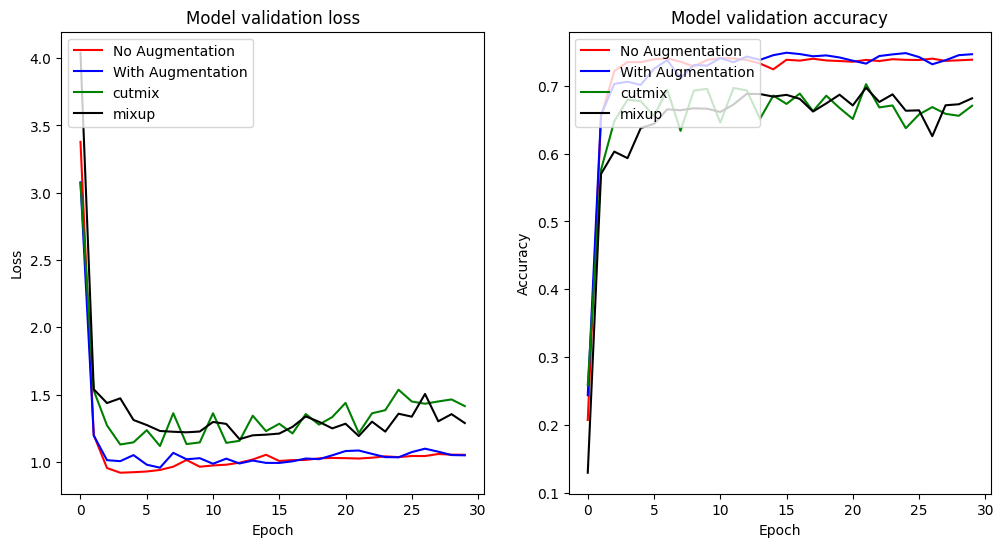

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50.history['val_loss'], 'r')
ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup.history['val_loss'], 'k')
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50.history['val_accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')


# fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
plt.show()

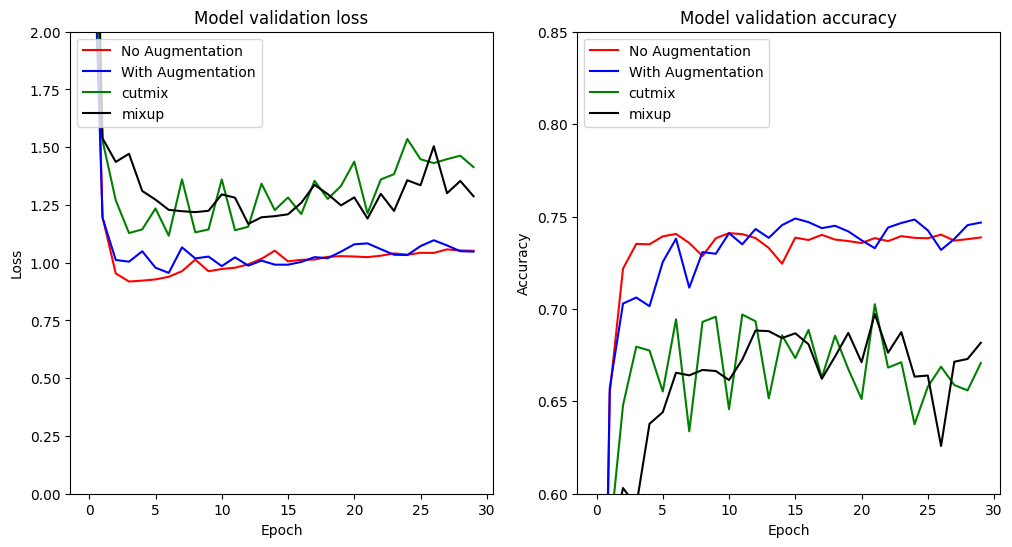

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50.history['val_loss'], 'r')
ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup.history['val_loss'], 'k')
ax1.set_ylim([0.00, 2]) # <<<<<
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50.history['val_accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
ax2.set_ylim([0.60, 0.85]) # <<<
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')


# fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
plt.show()

### More epoch

In [22]:
mixup_resnet50_2= keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

mixup_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
# mixup_resnet50_2.load_weights('/content/path_to_save_weights.h5')

In [ ]:
history_resnet50_mixup_2 = mixup_resnet50_2.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=150,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
cutmix_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
cutmix_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix_2 = cutmix_resnet50_2.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs= 150,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

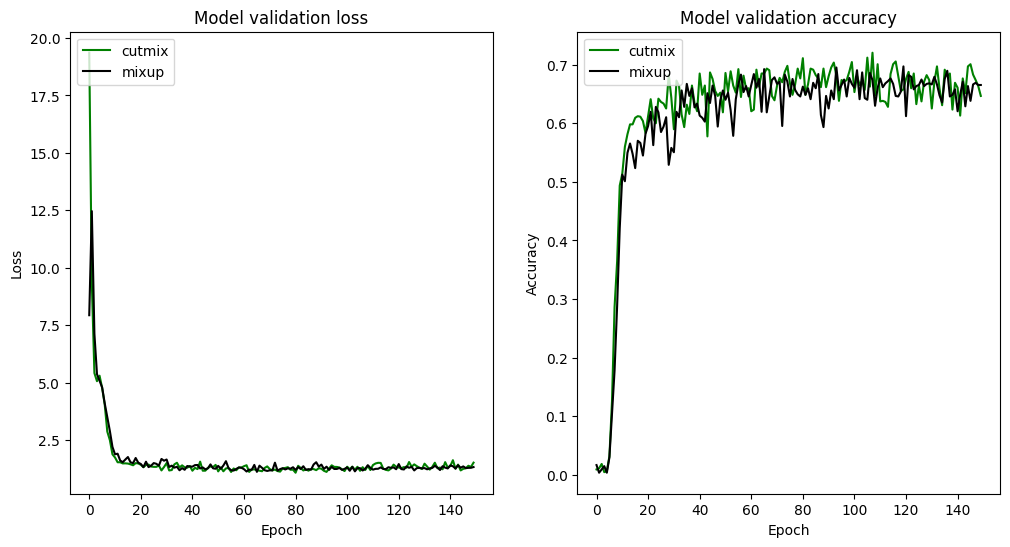

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#ax1.plot(history_resnet50.history['val_loss'], 'r')
#ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix_2.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup_2.history['val_loss'], 'k')
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['cutmix', 'mixup'], loc='upper left')

#ax2.plot(history_resnet50.history['val_accuracy'], 'r')
#ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix_2.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup_2.history['val_accuracy'], 'k')
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['cutmix', 'mixup'], loc='upper left')


# fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
plt.show()

### More epochs and more Batch size Adam Reduced on Plateau

In [ ]:
history_resnet50_mixup_2 = mixup_resnet50_2.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs= 600,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [24]:
mixup_resnet50_2.save_weights('path_to_save_weights.h5')
# mixup_resnet50_2.load_weights('/content/path_to_save_weights.h5')

In [ ]:
from keras.callbacks import ReduceLROnPlateau
batch_size = 32

cutmix_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# cutmix_resnet50_2.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )

cutmix_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.05),
    metrics=['accuracy'],
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    min_lr=0.0001
)

history_resnet50_cutmix_2 = cutmix_resnet50_2.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples / batch_size),
    epochs= 150,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[reduce_lr]
)

Epoch 1/150
375/375 [==============================] - 115s 207ms/step - loss: 4.8598 - accuracy: 0.0083 - val_loss: 4.7878 - val_accuracy: 0.0091 - lr: 0.0010
Epoch 2/150
375/375 [==============================] - 76s 204ms/step - loss: 4.8082 - accuracy: 0.0100 - val_loss: 4.8277 - val_accuracy: 0.0084 - lr: 0.0010
Epoch 3/150
375/375 [==============================] - 77s 204ms/step - loss: 4.7943 - accuracy: 0.0100 - val_loss: 6.8615 - val_accuracy: 0.0124 - lr: 0.0010
Epoch 4/150
375/375 [==============================] - 77s 204ms/step - loss: 4.7749 - accuracy: 0.0095 - val_loss: 4.7748 - val_accuracy: 0.0119 - lr: 0.0010
Epoch 5/150
375/375 [==============================] - 77s 204ms/step - loss: 4.7590 - accuracy: 0.0145 - val_loss: 4.8690 - val_accuracy: 0.0210 - lr: 0.0010
Epoch 6/150
375/375 [==============================] - 77s 205ms/step - loss: 4.7345 - accuracy: 0.0145 - val_loss: 4.7736 - val_accuracy: 0.0175 - lr: 0.0010
Epoch 7/150
375/375 [========================

In [ ]:
cutmix_resnet50_2.save_weights('path_to_save_weights.h5')
# cutmix_resnet50_2.load_weights('/content/path_to_save_weights.h5')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#ax1.plot(history_resnet50.history['val_loss'], 'r')
#ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
#ax1.plot(history_resnet50_cutmix_2.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup_2.history['val_loss'], 'k')
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['cutmix', 'mixup'], loc='upper left')

#ax2.plot(history_resnet50.history['val_accuracy'], 'r')
#ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
#ax2.plot(history_resnet50_cutmix_2.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup_2.history['val_accuracy'], 'k')
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['cutmix', 'mixup'], loc='upper left')


# fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
plt.show()